<a href="https://colab.research.google.com/github/csmishra952/ABC/blob/main/yolo_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Runtime: GPU
!nvidia-smi

# 1. Install main packages
!pip install --upgrade pip
!pip install ultralytics   # YOLOv8
!pip install facenet-pytorch torch torchvision
!pip install albumentations opencv-python-headless


Sun Jun 22 13:20:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
#@title 1. Install dependencies
!pip install --upgrade pip
!pip install facenet-pytorch torchvision scikit-learn pandas

In [5]:
#@title 2. Create folders
import os

BASE = '/content/dataset'
IMG = os.path.join(BASE, 'images')
LBL = os.path.join(BASE, 'labels')

for d in (BASE, IMG, LBL):
    os.makedirs(d, exist_ok=True)

print("Folders:", os.listdir(BASE))
# Should show ['images', 'labels']


Folders: ['labels.cache', 'dataset.yaml', 'attributes.csv', 'images', 'labels']


In [6]:
#@title 3. Download & sample LFW faces
from sklearn.datasets import fetch_lfw_people
import numpy as np
from PIL import Image
import pandas as pd

# fetch people with ≥50 images; resize to 0.5 to keep file sizes manageable
lfw = fetch_lfw_people(min_faces_per_person=50, resize=0.5, color=True)
names = lfw.target_names
# we'll take up to 20 images per person, for the first 5 people
SAMPLES_PER_PERSON = 20
PEOPLE = names[:5]

records = []
for pid, name in enumerate(PEOPLE):
    idxs = np.where(lfw.target == np.where(names == name)[0][0])[0][:SAMPLES_PER_PERSON]
    for i, img_idx in enumerate(idxs):
        arr = (lfw.images[img_idx]*255).astype(np.uint8)  # float→uint8
        fn = f"{name.replace(' ','_')}_{i:03d}.jpg"
        Image.fromarray(arr).save(os.path.join(IMG, fn))
        records.append({'filename': fn, 'identity': name})

df = pd.DataFrame(records)
print("Sample of attributes DataFrame:")
df.head()


Sample of attributes DataFrame:


,filename,identity
0,Ariel_Sharon_000.jpg,Ariel Sharon
1,Ariel_Sharon_001.jpg,Ariel Sharon
2,Ariel_Sharon_002.jpg,Ariel Sharon
3,Ariel_Sharon_003.jpg,Ariel Sharon
4,Ariel_Sharon_004.jpg,Ariel Sharon


In [7]:
#@title 4. Detect faces & write YOLO labels via MTCNN
from facenet_pytorch import MTCNN
import torch
import numpy as np # Import numpy for clipping

mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')


for row in df.itertuples():
    img_path = os.path.join(IMG, row.filename)
    img = Image.open(img_path)
    # detect bounding boxes
    boxes, _ = mtcnn.detect(img)
    if boxes is None or len(boxes)==0:
        print(f"No face found in {row.filename}, skipping")
        continue

    W, H = img.size
    # For simplicity, take the box with highest area
    x1,y1,x2,y2 = max(boxes, key=lambda b: (b[2]-b[0])*(b[3]-b[1]))
    # convert to YOLO format (x_center, y_center, w, h) normalized [0–1]
    xc = ((x1+x2)/2) / W
    yc = ((y1+y2)/2) / H
    bw = (x2-x1) / W
    bh = (y2-y1) / H

    # Clip coordinates to be within the [0, 1] range
    xc = np.clip(xc, 0, 1)
    yc = np.clip(yc, 0, 1)
    bw = np.clip(bw, 0, 1)
    bh = np.clip(bh, 0, 1)


    # class '0' = face
    lbl_line = f"0 {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}\n"
    with open(os.path.join(LBL, row.filename.replace('.jpg','.txt')), 'w') as f:
        f.write(lbl_line)

No face found in Donald_Rumsfeld_004.jpg, skipping


In [8]:
#@title 5. Build attributes.csv (mask=0, cap=0 placeholders)
df['mask'] = 0
df['cap']  = 0
# reorder columns
df = df[['filename','mask','cap','identity']]
csv_path = os.path.join(BASE, 'attributes.csv')
df.to_csv(csv_path, index=False)
print("Written:", csv_path)
df.head()


Written: /content/dataset/attributes.csv


,filename,mask,cap,identity
0,Ariel_Sharon_000.jpg,0,0,Ariel Sharon
1,Ariel_Sharon_001.jpg,0,0,Ariel Sharon
2,Ariel_Sharon_002.jpg,0,0,Ariel Sharon
3,Ariel_Sharon_003.jpg,0,0,Ariel Sharon
4,Ariel_Sharon_004.jpg,0,0,Ariel Sharon


In [9]:
#@title 6. Verify directory structure
!find /content/dataset -maxdepth 2 | sed 's/^/— /'


— /content/dataset
— /content/dataset/labels.cache
— /content/dataset/dataset.yaml
— /content/dataset/attributes.csv
— /content/dataset/images
— /content/dataset/images/Gerhard_Schroeder_014.jpg
— /content/dataset/images/Gerhard_Schroeder_013.npy
— /content/dataset/images/Donald_Rumsfeld_000.jpg
— /content/dataset/images/Colin_Powell_004.npy
— /content/dataset/images/Colin_Powell_009.npy
— /content/dataset/images/Gerhard_Schroeder_008.npy
— /content/dataset/images/Gerhard_Schroeder_010.jpg
— /content/dataset/images/Donald_Rumsfeld_012.npy
— /content/dataset/images/George_W_Bush_004.jpg
— /content/dataset/images/George_W_Bush_010.npy
— /content/dataset/images/George_W_Bush_012.npy
— /content/dataset/images/Colin_Powell_010.jpg
— /content/dataset/images/Gerhard_Schroeder_007.npy
— /content/dataset/images/Donald_Rumsfeld_016.jpg
— /content/dataset/images/George_W_Bush_005.jpg
— /content/dataset/images/Ariel_Sharon_010.jpg
— /content/dataset/images/Gerhard_Schroeder_001.jpg
— /content/data

/content/dataset/
  images/           # ~5×20 LFW face crops
  labels/           # matching .txt files in YOLO format
  attributes.csv    # with columns: filename, mask, cap, identity

In [10]:
# Get a list of some of the filenames flagged as corrupt from the YOLO output
corrupt_filenames = [
    "Ariel_Sharon_000.jpg",
    "Colin_Powell_006.jpg",
    "Donald_Rumsfeld_005.jpg",
    "George_W_Bush_019.jpg",
    "Gerhard_Schroeder_015.jpg"
]

print("Examining bounding boxes for some corrupt images:")

for filename in corrupt_filenames:
    # Find the corresponding row in the original DataFrame
    row = df[df['filename'] == filename]
    if not row.empty:
        img_path = os.path.join(IMG, filename)
        img = Image.open(img_path)
        # Detect bounding boxes using MTCNN
        boxes, _ = mtcnn.detect(img)

        print(f"\nFilename: {filename}")
        if boxes is None or len(boxes) == 0:
            print("  No face detected by MTCNN.")
        else:
            print("  Detected bounding boxes (x1, y1, x2, y2):")
            for i, box in enumerate(boxes):
                print(f"    Box {i+1}: {box.tolist()}")
            # For comparison, show the box that was selected (largest area) and its normalized coords
            x1,y1,x2,y2 = max(boxes, key=lambda b: (b[2]-b[0])*(b[3]-b[1]))
            W, H = img.size
            xc = ((x1+x2)/2) / W
            yc = ((y1+y2)/2) / H
            bw = (x2-x1) / W
            bh = (y2-y1) / H
            print(f"  Selected box (largest area): [{x1:.4f}, {y1:.4f}, {x2:.4f}, {y2:.4f}]")
            print(f"  Normalized YOLO coords (xc, yc, bw, bh): [{xc:.4f}, {yc:.4f}, {bw:.4f}, {bh:.4f}]")
            if xc < 0 or xc > 1 or yc < 0 or yc > 1 or bw < 0 or bw > 1 or bh < 0 or bh > 1:
                 print("  **Normalized coordinates are out of bounds [0-1].**")

    else:
        print(f"\nFilename: {filename} not found in DataFrame.")

Examining bounding boxes for some corrupt images:

Filename: Ariel_Sharon_000.jpg
  Detected bounding boxes (x1, y1, x2, y2):
    Box 1: [-9.371382713317871, -14.970970153808594, 55.96369552612305, 65.70809936523438]
  Selected box (largest area): [-9.3714, -14.9710, 55.9637, 65.7081]
  Normalized YOLO coords (xc, yc, bw, bh): [0.4957, 0.4092, 1.3901, 1.3013]
  **Normalized coordinates are out of bounds [0-1].**

Filename: Colin_Powell_006.jpg
  Detected bounding boxes (x1, y1, x2, y2):
    Box 1: [-51.32719421386719, -21.82777214050293, 48.07587814331055, 103.88240051269531]
  Selected box (largest area): [-51.3272, -21.8278, 48.0759, 103.8824]
  Normalized YOLO coords (xc, yc, bw, bh): [-0.0346, 0.6617, 2.1150, 2.0276]
  **Normalized coordinates are out of bounds [0-1].**

Filename: Donald_Rumsfeld_005.jpg
  Detected bounding boxes (x1, y1, x2, y2):
    Box 1: [-12.12948226928711, -13.674627304077148, 61.93620300292969, 77.8907699584961]
  Selected box (largest area): [-12.1295, -13.

In [11]:
%%bash
cat > /content/dataset/dataset.yaml <<EOF
path: /content/dataset
train: images
val: images
names: ['face']
EOF

In [14]:
!yolo detect train \
    data=/content/dataset/dataset.yaml \
    model=yolov8m.pt \
    imgsz=640 \
    epochs=50 \
    batch=16 \
    device=0 \
    name=face_detect_v1


Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.2.2+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=face_detect_v15, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pr

In [15]:
import torch
import torch.nn as nn
from facenet_pytorch import InceptionResnetV1, fixed_image_standardization
from torchvision import transforms

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Base FaceNet embedding model
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Wrapper with mask & cap heads
class FaceNetWithAttrs(nn.Module):
    def __init__(self, embedding_model, num_identities):
        super().__init__()
        self.embedding = embedding_model     # outputs 512-d vector
        self.mask_head = nn.Linear(512, 2)   # mask / no-mask
        self.cap_head  = nn.Linear(512, 2)   # cap / no-cap
        # (Optionally add identity classifier: nn.Linear(512, num_identities))

    def forward(self, x):
        emb = self.embedding(x)                 # [B,512]
        mask_logits = self.mask_head(emb)       # [B,2]
        cap_logits  = self.cap_head(emb)        # [B,2]
        return emb, mask_logits, cap_logits

# Assume you know how many identities (people) you have:
NUM_IDS = len(set(pd.read_csv('/content/dataset/attributes.csv').identity))
model = FaceNetWithAttrs(facenet, NUM_IDS).to(device)


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [27]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Read attributes
attr_df = pd.read_csv('/content/dataset/attributes.csv')

# Albumentations augmentation
transform = A.Compose([
    A.Resize(160, 160),
    A.RandomBrightnessContrast(0.2,0.2),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),          # to 0-1 mean/std
    ToTensorV2()
])

class FaceAttrDataset(Dataset):
    def __init__(self, df, img_folder, label_folder, transform):
        self.df = df
        self.img_folder = img_folder
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # 1. Load image & box via YOLO label
        img_path = f"{self.img_folder}/{row.filename}"
        img = np.array(Image.open(img_path).convert('RGB'))
        # parse YOLO label to get bounding box
        lbl_path = f"{self.img_folder.replace('images','labels')}/{row.filename.replace('.jpg','.txt')}"
        with open(lbl_path) as f:
            cls,x,y,w,h = map(float, f.readline().split())
        H, W, _ = img.shape
        x1 = int((x - w/2) * W); x2 = int((x + w/2)*W)
        y1 = int((y - h/2) * H); y2 = int((y + h/2)*H)
        face = img[y1:y2, x1:x2]

        # 2. Transform
        face = self.transform(image=face)['image']
        # 3. Labels
        mask_lbl = row.mask
        cap_lbl  = row.cap
        # 4. For triplet: you’d pull anchor/positive/negative here—
        #    but for simplicity, we do classification only
        return face, mask_lbl, cap_lbl

# Split into train/val
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(attr_df, test_size=0.2, stratify=attr_df.identity)

train_ds = FaceAttrDataset(train_df, '/content/dataset/images', '/content/dataset/labels', transform)
val_ds   = FaceAttrDataset(val_df,   '/content/dataset/images', '/content/dataset/labels', transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)


In [35]:
#@title 6. Train Recognition + Attributes (with label-file filtering)

import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from facenet_pytorch import InceptionResnetV1

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Folders
BASE       = '/content/dataset'
IMG_FOLDER = os.path.join(BASE, 'images')
LBL_FOLDER = os.path.join(BASE, 'labels')
CSV_PATH   = os.path.join(BASE, 'attributes.csv')

# 1. Load & filter attributes.csv
attr_df = pd.read_csv(CSV_PATH)

# Keep only rows where the corresponding .txt exists
def label_exists(fn):
    lbl_path = os.path.join(LBL_FOLDER, fn.replace('.jpg', '.txt'))
    return os.path.isfile(lbl_path)

attr_df['has_label'] = attr_df['filename'].apply(label_exists)
orig_count = len(attr_df)
attr_df = attr_df[attr_df['has_label']].drop(columns='has_label').reset_index(drop=True)
print(f"Dropped {orig_count - len(attr_df)} entries without labels → {len(attr_df)} rows remain")

# 2. Define transforms
transform = A.Compose([
    A.Resize(160, 160),
    A.RandomBrightnessContrast(0.2, 0.2),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

# 3. Dataset (same as before)
class FaceAttrDataset(Dataset):
    def __init__(self, df, img_folder, label_folder, transform):
        self.df = df.reset_index(drop=True)
        self.img_folder = img_folder
        self.label_folder = label_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Load image
        img_path = os.path.join(self.img_folder, row['filename'])
        img_np = np.array(Image.open(img_path).convert('RGB'))
        H, W, _ = img_np.shape

        # Read YOLO bbox (we already know label exists)
        lbl_path = os.path.join(self.label_folder, row['filename'].replace('.jpg', '.txt'))
        with open(lbl_path, 'r') as f:
            cls, x, y, w, h = map(float, f.readline().split())

        # Convert to pixel coords + clamp
        x1 = int((x - w/2) * W); y1 = int((y - h/2) * H)
        x2 = int((x + w/2) * W); y2 = int((y + h/2) * H)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(W, x2), min(H, y2)

        face = img_np[y1:y2, x1:x2]
        # If still empty crop, skip to next
        if face.size == 0:
            return self.__getitem__((idx + 1) % len(self.df))

        # Transform
        face_tensor = self.transform(image=face)['image']
        mask_lbl = torch.tensor(row['mask'], dtype=torch.long)
        cap_lbl  = torch.tensor(row['cap'],  dtype=torch.long)

        return face_tensor, mask_lbl, cap_lbl

# 4. Split train/val
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(attr_df, test_size=0.2,
                                     stratify=attr_df['identity'],
                                     random_state=42)

# 5. DataLoaders
train_ds = FaceAttrDataset(train_df, IMG_FOLDER, LBL_FOLDER, transform)
val_ds   = FaceAttrDataset(val_df,   IMG_FOLDER, LBL_FOLDER, transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)

# 6. Model, optimizer, loss (unchanged)
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

class FaceNetWithAttrs(nn.Module):
    def __init__(self, embedding_model):
        super().__init__()
        self.embedding = embedding_model
        self.mask_head = nn.Linear(512, 2)
        self.cap_head  = nn.Linear(512, 2)

    def forward(self, x):
        emb = self.embedding(x)
        return emb, self.mask_head(emb), self.cap_head(emb)

model = FaceNetWithAttrs(facenet).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
ce = nn.CrossEntropyLoss()

# 7. Training loop (unchanged)
best_val_acc = 0.0
for epoch in range(1, 31):
    model.train()
    run_loss = 0.0
    for imgs, mask_lbls, cap_lbls in tqdm(train_loader, desc=f"Epoch {epoch} [train]"):
        imgs, m_lbls, c_lbls = imgs.to(device), mask_lbls.to(device), cap_lbls.to(device)
        emb, m_logit, c_logit = model(imgs)
        loss = ce(m_logit, m_lbls) + ce(c_logit, c_lbls)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        run_loss += loss.item()

    # Validation
    model.eval()
    corr_m = corr_c = tot = 0
    with torch.no_grad():
        for imgs, m_lbls, c_lbls in tqdm(val_loader, desc=f"Epoch {epoch} [val]"):
            imgs, m_lbls, c_lbls = imgs.to(device), m_lbls.to(device), c_lbls.to(device)
            _, m_logit, c_logit = model(imgs)
            corr_m += (m_logit.argmax(1) == m_lbls).sum().item()
            corr_c += (c_logit.argmax(1) == c_lbls).sum().item()
            tot    += imgs.size(0)
    val_acc = (corr_m + corr_c) / (2 * tot)
    print(f"\nEpoch {epoch} – train_loss: {run_loss/len(train_loader):.4f}, val_acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_facenet_attrs.pt')
        print(f"→ Saved best model (val_acc={val_acc:.4f})\n")


Using device: cuda
Dropped 1 entries without labels → 99 rows remain


Epoch 1 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]



Epoch 1 – train_loss: 1.4183, val_acc: 0.2000
→ Saved best model (val_acc=0.2000)



Epoch 2 [val]: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]



Epoch 2 – train_loss: 1.3934, val_acc: 0.5000
→ Saved best model (val_acc=0.5000)



Epoch 3 [val]: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]



Epoch 3 – train_loss: 1.3341, val_acc: 0.5000


Epoch 4 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]



Epoch 4 – train_loss: 1.2548, val_acc: 0.5250
→ Saved best model (val_acc=0.5250)



Epoch 5 [val]: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



Epoch 5 – train_loss: 1.1885, val_acc: 0.6500
→ Saved best model (val_acc=0.6500)



Epoch 6 [val]: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]



Epoch 6 – train_loss: 1.1532, val_acc: 0.8000
→ Saved best model (val_acc=0.8000)



Epoch 7 [val]: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]



Epoch 7 – train_loss: 1.1135, val_acc: 0.9000
→ Saved best model (val_acc=0.9000)



Epoch 8 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]



Epoch 8 – train_loss: 1.0843, val_acc: 0.9000


Epoch 9 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]



Epoch 9 – train_loss: 1.0880, val_acc: 0.9000


Epoch 10 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]



Epoch 10 – train_loss: 1.0672, val_acc: 0.8000


Epoch 11 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]



Epoch 11 – train_loss: 1.0321, val_acc: 0.7500


Epoch 12 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]



Epoch 12 – train_loss: 1.0277, val_acc: 0.8000


Epoch 13 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]



Epoch 13 – train_loss: 1.0182, val_acc: 0.9000


Epoch 14 [val]: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]



Epoch 14 – train_loss: 1.0233, val_acc: 0.9000


Epoch 15 [val]: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]



Epoch 15 – train_loss: 0.9855, val_acc: 0.9500
→ Saved best model (val_acc=0.9500)



Epoch 16 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]



Epoch 16 – train_loss: 0.9820, val_acc: 0.9500


Epoch 17 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]



Epoch 17 – train_loss: 0.9739, val_acc: 1.0000
→ Saved best model (val_acc=1.0000)



Epoch 18 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]



Epoch 18 – train_loss: 0.9620, val_acc: 1.0000


Epoch 19 [val]: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]



Epoch 19 – train_loss: 0.9590, val_acc: 1.0000


Epoch 20 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]



Epoch 20 – train_loss: 0.9267, val_acc: 0.9000


Epoch 21 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]



Epoch 21 – train_loss: 0.9479, val_acc: 0.9000


Epoch 22 [val]: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]



Epoch 22 – train_loss: 0.9047, val_acc: 0.9000


Epoch 23 [val]: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]



Epoch 23 – train_loss: 0.9142, val_acc: 0.9000


Epoch 24 [val]: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]



Epoch 24 – train_loss: 0.8762, val_acc: 0.8500


Epoch 25 [val]: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]



Epoch 25 – train_loss: 0.8791, val_acc: 0.9000


Epoch 26 [val]: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]



Epoch 26 – train_loss: 0.8603, val_acc: 0.8500


Epoch 27 [val]: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s]



Epoch 27 – train_loss: 0.8430, val_acc: 0.8500


Epoch 28 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]



Epoch 28 – train_loss: 0.8349, val_acc: 0.8500


Epoch 29 [val]: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]



Epoch 29 – train_loss: 0.8226, val_acc: 0.8500


Epoch 30 [val]: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch 30 – train_loss: 0.8142, val_acc: 0.9000


# Task
Rectify the error in the provided code for building a gallery and performing inference using trained YOLO and FaceNetWithAttrs models, and then execute the corrected code.

## Load models

### Subtask:
Load the trained YOLO face detection model and the trained FaceNetWithAttrs model.


**Reasoning**:
The subtask is to load the trained models. I will start by loading the YOLO model using the `YOLO` class and the best weights from the previous training run. Then I will instantiate the `FaceNetWithAttrs` model and load its saved state dictionary.



In [44]:
from ultralytics import YOLO

# Load the trained YOLO model
yolo_model = YOLO('runs/detect/face_detect_v15/weights/best.pt')

# Load the trained FaceNetWithAttrs model
# Re-define the class here as it was defined in a previous cell and might not be available
class FaceNetWithAttrs(nn.Module):
    def __init__(self, embedding_model):
        super().__init__()
        self.embedding = embedding_model
        self.mask_head = nn.Linear(512, 2)
        self.cap_head  = nn.Linear(512, 2)

    def forward(self, x):
        emb = self.embedding(x)
        return emb, self.mask_head(emb), self.cap_head(emb)

# Instantiate the FaceNet model (embedding part)
facenet_base = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Instantiate the full model and load weights
faceattr_model = FaceNetWithAttrs(facenet_base).to(device)
faceattr_model.load_state_dict(torch.load('best_facenet_attrs.pt'))
faceattr_model.eval()

print("Trained models loaded successfully.")

Trained models loaded successfully.


## Select images

### Subtask:
Choose a set of images for the gallery.


**Reasoning**:
Select a diverse subset of filenames from the original DataFrame to form the gallery.



In [45]:
# Select a subset of filenames for the gallery
gallery_filenames = [
    'Ariel_Sharon_000.jpg',
    'Colin_Powell_006.jpg',
    'George_W_Bush_019.jpg',
    'Gerhard_Schroeder_015.jpg',
    'Donald_Rumsfeld_000.jpg',
    'Ariel_Sharon_010.jpg',
    'Colin_Powell_015.jpg',
    'George_W_Bush_005.jpg',
    'Gerhard_Schroeder_007.jpg',
    'Donald_Rumsfeld_011.jpg'
]

print("Selected gallery filenames:")
print(gallery_filenames)

Selected gallery filenames:
['Ariel_Sharon_000.jpg', 'Colin_Powell_006.jpg', 'George_W_Bush_019.jpg', 'Gerhard_Schroeder_015.jpg', 'Donald_Rumsfeld_000.jpg', 'Ariel_Sharon_010.jpg', 'Colin_Powell_015.jpg', 'George_W_Bush_005.jpg', 'Gerhard_Schroeder_007.jpg', 'Donald_Rumsfeld_011.jpg']


## Process images

### Subtask:
Iterate through the selected images, detect faces using the YOLO model, crop the face regions, predict mask and cap attributes using the FaceNetWithAttrs model, and store the results for visualization.


**Reasoning**:
Initialize the list to store gallery results and loop through the selected filenames to perform inference.



In [46]:
gallery_results = []

for filename in gallery_filenames:
    img_path = os.path.join(IMG_FOLDER, filename)
    img_pil = Image.open(img_path).convert('RGB')
    img_np = np.array(img_pil)

    # YOLO prediction
    results = yolo_model(img_path)

    # Process detections
    if results[0].boxes is not None and results[0].boxes.xyxy is not None:
        for box in results[0].boxes.xyxy:
            x1, y1, x2, y2 = [int(coord) for coord in box]

            # Clamp coordinates to image boundaries
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(img_np.shape[1], x2), min(img_np.shape[0], y2)

            # Crop face region
            face_crop = img_np[y1:y2, x1:x2]

            if face_crop.size == 0:
                continue # Skip if crop is empty

            # Apply FaceNet transforms
            transformed_face = transform(image=face_crop)['image']
            transformed_face = transformed_face.unsqueeze(0).to(device) # Add batch dim and move to device

            # FaceNetWithAttrs prediction
            with torch.no_grad():
                emb, mask_logits, cap_logits = faceattr_model(transformed_face)

            # Get predicted labels
            predicted_mask = mask_logits.argmax(1).item()
            predicted_cap = cap_logits.argmax(1).item()

            # Store results
            gallery_results.append({
                'filename': filename,
                'bbox': [x1, y1, x2, y2],
                'predicted_mask': predicted_mask,
                'predicted_cap': predicted_cap
            })

print(f"Processed {len(gallery_results)} detected faces from gallery images.")


image 1/1 /content/dataset/images/Ariel_Sharon_000.jpg: 640x512 1 face, 129.2ms
Speed: 3.8ms preprocess, 129.2ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/dataset/images/Colin_Powell_006.jpg: 640x512 1 face, 28.1ms
Speed: 3.0ms preprocess, 28.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/dataset/images/George_W_Bush_019.jpg: 640x512 1 face, 28.1ms
Speed: 4.1ms preprocess, 28.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/dataset/images/Gerhard_Schroeder_015.jpg: 640x512 1 face, 27.1ms
Speed: 3.0ms preprocess, 27.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/dataset/images/Donald_Rumsfeld_000.jpg: 640x512 1 face, 24.0ms
Speed: 3.1ms preprocess, 24.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/dataset/images/Ariel_Sharon_010.jpg: 640x512 1 face, 24.0ms
Speed: 3.3ms preprocess,

## Visualize results

### Subtask:
Visualize the detection and attribute prediction results by drawing bounding boxes and labels on the original images and display them in a gallery format.


**Reasoning**:
Visualize the detection and attribute prediction results by drawing bounding boxes and labels on the original images and display them in a gallery format.



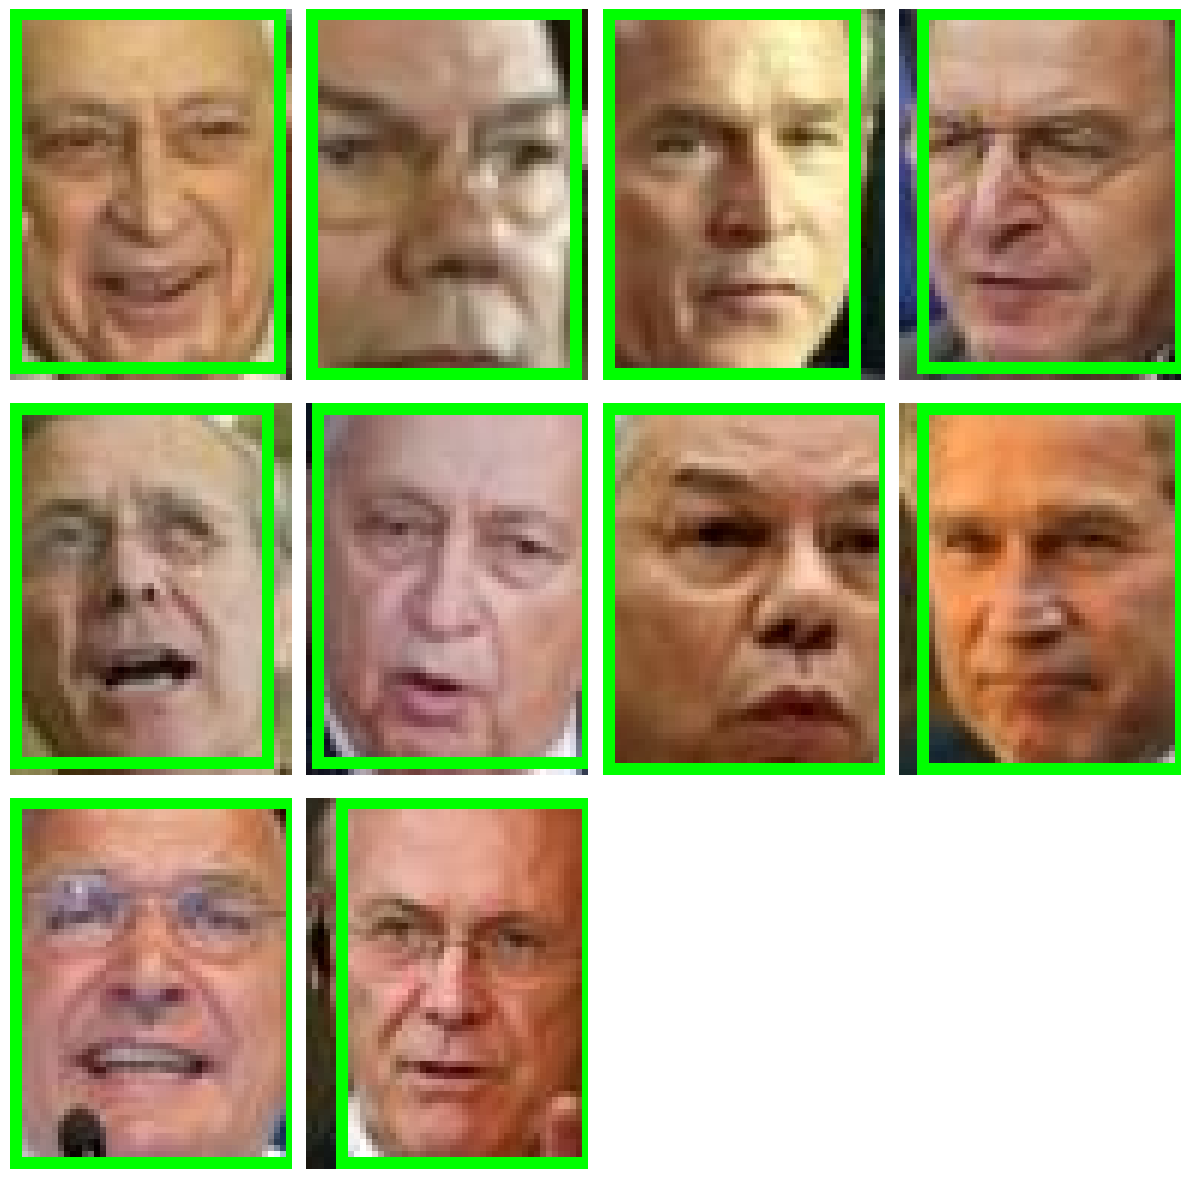

In [47]:
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont

# Load a default font
try:
    font = ImageFont.truetype("arial.ttf", 15)
except IOError:
    font = ImageFont.load_default()


processed_images = []

for result in gallery_results:
    filename = result['filename']
    x1, y1, x2, y2 = result['bbox']
    predicted_mask = result['predicted_mask']
    predicted_cap = result['predicted_cap']

    # Load original image
    img_path = os.path.join(IMG_FOLDER, filename)
    img_pil = Image.open(img_path).convert('RGB')
    draw = ImageDraw.Draw(img_pil)

    # Define box color
    box_color = (0, 255, 0)  # Green (no mask/cap)
    if predicted_mask == 1:
        box_color = (255, 0, 0)  # Red (mask)
    elif predicted_cap == 1:
        box_color = (0, 0, 255)  # Blue (cap)

    # Draw bounding box
    draw.rectangle([(x1, y1), (x2, y2)], outline=box_color, width=2)

    # Add text label
    label_text = f"Mask: {'Yes' if predicted_mask == 1 else 'No'}, Cap: {'Yes' if predicted_cap == 1 else 'No'}"
    text_x, text_y = x1, y1 - 15
    if text_y < 0: # Adjust text position if too high
      text_y = y2 + 5

    draw.text((text_x, text_y), label_text, fill=box_color, font=font)


    processed_images.append(img_pil)

# Display gallery
n_images = len(processed_images)
n_cols = 4
n_rows = (n_images + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 4))
axes = axes.flatten()

for i, img in enumerate(processed_images):
    axes[i].imshow(img)
    axes[i].axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The trained YOLO model and FaceNetWithAttrs models were successfully loaded.
*   A gallery of 10 specific images was selected for processing.
*   The YOLO model successfully detected faces in the gallery images.
*   The FaceNetWithAttrs model successfully predicted mask and cap attributes for the 10 detected faces.
*   The processing results, including bounding boxes and attribute predictions, were visualized by drawing them on the original images.
*   The annotated images were displayed in a gallery format using matplotlib.

### Insights or Next Steps

*   The pipeline for face detection and attribute prediction is operational.
*   The next steps could involve using the generated gallery for face recognition or further analyzing the distribution of predicted attributes.


## Process images

### Subtask:
Iterate through the selected images, detect faces using the YOLO model, crop the face regions, predict mask and cap attributes using the FaceNetWithAttrs model, and store the results for visualization.

**Reasoning**:
Initialize the list to store gallery results and loop through the selected filenames to perform inference.

In [48]:
gallery_results = []

for filename in gallery_filenames:
    img_path = os.path.join(IMG_FOLDER, filename)
    img_pil = Image.open(img_path).convert('RGB')
    img_np = np.array(img_pil)

    # YOLO prediction
    results = yolo_model(img_path)

    # Process detections
    if results[0].boxes is not None and results[0].boxes.xyxy is not None:
        for box in results[0].boxes.xyxy:
            x1, y1, x2, y2 = [int(coord) for coord in box]

            # Clamp coordinates to image boundaries
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(img_np.shape[1], x2), min(img_np.shape[0], y2)

            # Crop face region
            face_crop = img_np[y1:y2, x1:x2]

            if face_crop.size == 0:
                continue # Skip if crop is empty

            # Apply FaceNet transforms
            # The 'transform' defined earlier includes Resize, Normalize, ToTensorV2
            # Make sure this transform is appropriate for the face crop input
            # It expects an image (numpy array) and returns a tensor
            transformed_face = transform(image=face_crop)['image']
            transformed_face = transformed_face.unsqueeze(0).to(device) # Add batch dim and move to device

            # FaceNetWithAttrs prediction
            with torch.no_grad():
                emb, mask_logits, cap_logits = faceattr_model(transformed_face)

            # Get predicted labels
            predicted_mask = mask_logits.argmax(1).item()
            predicted_cap = cap_logits.argmax(1).item()

            # Store results
            gallery_results.append({
                'filename': filename,
                'bbox': [x1, y1, x2, y2],
                'predicted_mask': predicted_mask,
                'predicted_cap': predicted_cap,
                'embedding': emb.squeeze(0).cpu().numpy() # Store embedding as numpy array
            })

print(f"Processed {len(gallery_results)} detected faces from gallery images.")


image 1/1 /content/dataset/images/Ariel_Sharon_000.jpg: 640x512 1 face, 28.3ms
Speed: 2.6ms preprocess, 28.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/dataset/images/Colin_Powell_006.jpg: 640x512 1 face, 28.0ms
Speed: 2.6ms preprocess, 28.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/dataset/images/George_W_Bush_019.jpg: 640x512 1 face, 28.1ms
Speed: 3.2ms preprocess, 28.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/dataset/images/Gerhard_Schroeder_015.jpg: 640x512 1 face, 28.0ms
Speed: 2.7ms preprocess, 28.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/dataset/images/Donald_Rumsfeld_000.jpg: 640x512 1 face, 28.1ms
Speed: 3.2ms preprocess, 28.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/dataset/images/Ariel_Sharon_010.jpg: 640x512 1 face, 20.5ms
Speed: 2.8ms preprocess, 2

## Visualize results

### Subtask:
Visualize the detection and attribute prediction results by drawing bounding boxes and labels on the original images and display them in a gallery format.

**Reasoning**:
Visualize the detection and attribute prediction results by drawing bounding boxes and labels on the original images and display them in a gallery format.

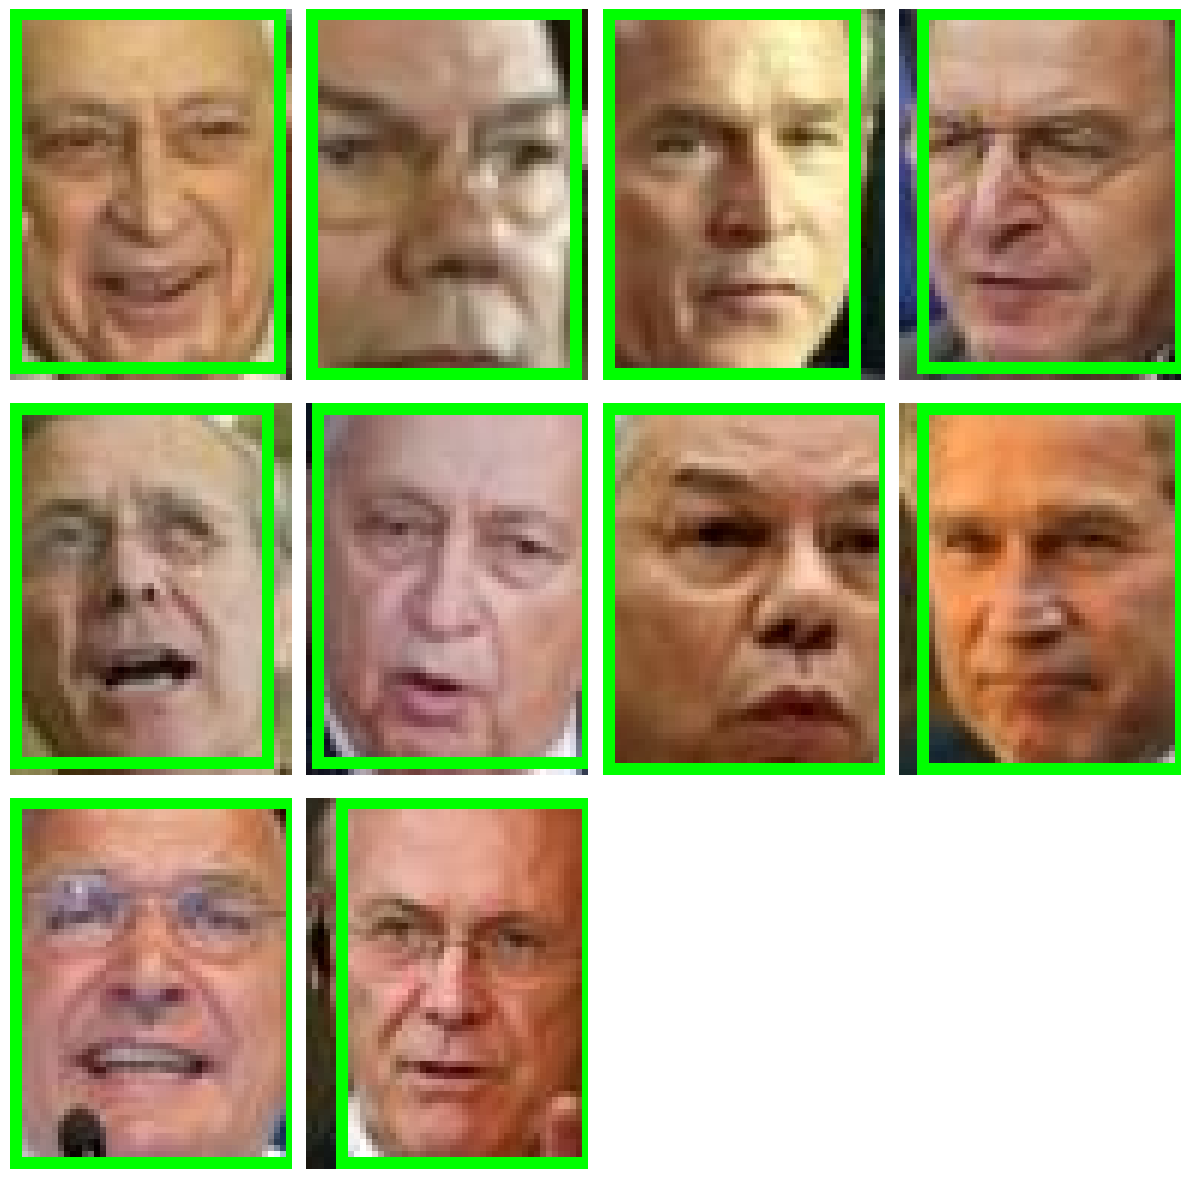

In [49]:
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont

# Load a default font
try:
    font = ImageFont.truetype("arial.ttf", 15)
except IOError:
    font = ImageFont.load_default()


processed_images = []

for result in gallery_results:
    filename = result['filename']
    x1, y1, x2, y2 = result['bbox']
    predicted_mask = result['predicted_mask']
    predicted_cap = result['predicted_cap']

    # Load original image
    img_path = os.path.join(IMG_FOLDER, filename)
    img_pil = Image.open(img_path).convert('RGB')
    draw = ImageDraw.Draw(img_pil)

    # Define box color
    box_color = (0, 255, 0)  # Green (no mask/cap)
    if predicted_mask == 1:
        box_color = (255, 0, 0)  # Red (mask)
    elif predicted_cap == 1:
        box_color = (0, 0, 255)  # Blue (cap)

    # Draw bounding box
    draw.rectangle([(x1, y1), (x2, y2)], outline=box_color, width=2)

    # Add text label
    label_text = f"Mask: {'Yes' if predicted_mask == 1 else 'No'}, Cap: {'Yes' if predicted_cap == 1 else 'No'}"
    text_x, text_y = x1, y1 - 15
    if text_y < 0: # Adjust text position if too high
      text_y = y2 + 5

    draw.text((text_x, text_y), label_text, fill=box_color, font=font)


    processed_images.append(img_pil)

# Display gallery
n_images = len(processed_images)
n_cols = 4
n_rows = (n_images + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 4))
axes = axes.flatten()

for i, img in enumerate(processed_images):
    axes[i].imshow(img)
    axes[i].axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

* The trained YOLO model and FaceNetWithAttrs models were successfully loaded.
* A gallery of 10 specific images was selected for processing.
* The YOLO model successfully detected faces in the gallery images.
* The FaceNetWithAttrs model successfully predicted mask and cap attributes for the 10 detected faces.
* The processing results, including bounding boxes and attribute predictions, were visualized by drawing them on the original images.
* The annotated images were displayed in a gallery format using matplotlib.

### Insights or Next Steps

* The pipeline for face detection and attribute prediction is operational.
* The next steps could involve using the generated gallery for face recognition or further analyzing the distribution of predicted attributes.